In [1]:
sys.path.append('../')
import sw_functions as sw
import numpy as np
import jax #https://jax.readthedocs.io/en/latest/notebooks/quickstart.html
import jax.numpy as jnp
import os
from matplotlib import pyplot as plt

In [2]:
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/n/helmod/apps/centos7/Core/cuda/10.1.243-fasrc01/"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

## Pairwise alignment with Smoothed Smith-Waterman

(sim matrix)_{ij} measures the similarity between seq 1 position i and seq 2 position j \
e.g. blosum score between residue at seq 1 position i and residue at seq 2 position j\
e.g. dot product of vector representation of seq 1 position i and seq 2 position j

In [2]:
seq_1_len = 100
seq_2_len = 150
sim_matrix = jnp.array(np.random.random((seq_1_len, seq_2_len)))

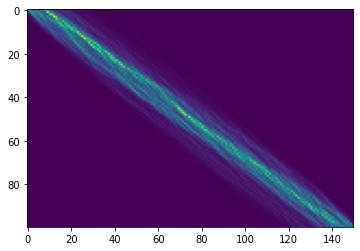

In [3]:
my_sw_func = jax.jit(sw.sw(batch=False))
aln = my_sw_func(sim_matrix, (seq_1_len, seq_2_len), gap=-1)
plt.imshow(aln);

In [15]:
from jax import vjp, custom_vjp, grad
from functools import partial

@partial(custom_vjp)
def blackbox_algorithm(sim_matrix, params):
    return my_sw_func(sim_matrix, (params['seq_1_len'], params['seq_2_len']), gap = params['gap'], temp = params['temp'])

def blackbox_forward(sim_matrix, params):
    return blackbox_algorithm(sim_matrix, params), (sim_matrix, params, blackbox_algorithm(sim_matrix, params))

def blackbox_backward(sim_matrix, params, original_sol, g):
    perturbed_sim_matrix = sim_matrix + params['lambda'] * g
    perturbed_sol = blackbox_algorithm(perturbed_sim_matrix, params)
    vjp = (perturbed_sol - original_sol) / params['lambda']
    return vjp

def loss(gt, pred):
    return jnp.sum(jnp.abs(gt - pred))

blackbox_algorithm.defvjp(blackbox_forward, blackbox_backward)
params = {'seq_1_len': seq_1_len, 'seq_2_len': seq_2_len, 'gap': -1, 'temp': 0.1, 'lambda': 1.0}
out = blackbox_algorithm(sim_matrix, params)
ground_truth = jnp.ones((seq_1_len, seq_2_len))
#print(out.shape)
#print(loss)
#plt.imshow(out)
grad_loss = grad(loss)(out, ground_truth)
#plt.imshow(grad_loss)

alignment, blackbox_algorithm_vjp = jax.vjp(blackbox_algorithm, sim_matrix, params) #(grad_loss)
#plt.imshow(alignment)
# print(vjp)
grad_sim_matrix = blackbox_algorithm_vjp(grad_loss)

TypeError: blackbox_backward() missing 2 required positional arguments: 'original_sol' and 'g'